# GA Data Science (DAT16) - Lab 15
## Deep Learning


In [1]:
# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline


In [2]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [3]:
# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=0)


In [4]:

# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

## Training

Hyper-parameters. These were set by cross-validation,using a GridSearchCV. Here we are not performing cross-validation to save time.

In [5]:
rbm.learning_rate = 0.06
rbm.n_iter = 20

More components tend to give better prediction performance, but larger fitting time

In [6]:
rbm.n_components = 20
logistic.C = 6000.0

In [7]:
# Training RBM-Logistic Pipeline
classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.60, time = 0.10s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -24.10, time = 0.12s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -23.22, time = 0.13s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -22.76, time = 0.13s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.98, time = 0.12s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.69, time = 0.12s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -21.30, time = 0.12s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -21.19, time = 0.11s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -21.01, time = 0.12s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -21.17, time = 0.12s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.76, time = 0.13s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -20.56, time = 0.12s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -20.59, time = 0.12s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -20.61, time = 0.11s
[BernoulliRBM] Iteration 15, 

Pipeline(steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.06, n_components=20, n_iter=20,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=6000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0))])

In [8]:
# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)
logistic_classifier.fit(X_train, Y_train)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

##Evaluation

In [9]:
print()
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        classifier.predict(X_test))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        Y_test,
        logistic_classifier.predict(X_test))))

()
Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.88      0.95      0.91       174
          1       0.75      0.76      0.75       184
          2       0.75      0.83      0.79       166
          3       0.69      0.72      0.71       194
          4       0.88      0.87      0.87       186
          5       0.59      0.60      0.60       181
          6       0.92      0.92      0.92       207
          7       0.82      0.89      0.85       154
          8       0.64      0.54      0.59       182
          9       0.56      0.48      0.52       169

avg / total       0.75      0.76      0.75      1797


Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.85      0.94      0.89       174
          1       0.57      0.55      0.56       184
          2       0.72      0.85      0.78       166
          3       0.76      0.74      0.75       194
     

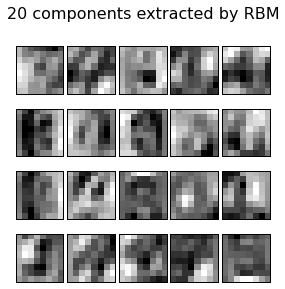

In [10]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(4, 5, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('20 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()